# Indicative Planning

Notebook to take fitted transition parameters and simulate hospital bed occupancy


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.special as sp
import scipy.optimize as op
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import networkx as nx
import seaborn as sns
import random

## MS Model on Hospital Data

In [2]:
state_names = {
    1: "Acute Ward",
    2: "ICU",
    3: "Recovery",
    4: "Discharge",
    5: "Mortality"  
}

In [3]:
nstates = len(state_names)

In [4]:
TransNum = pd.read_csv('./fitted_parameters/Q.csv').values
TransNum[2,4] = 0  # We happen not to see people dying from ICU recovery, although this could happen so don't want to hard code
num_trans = np.max(TransNum)
Qbase = TransNum.copy()
Qbase[Qbase>0]=1

In [5]:
# # Hospital Data
kboot = pd.read_csv('./fitted_parameters/kboots.csv').values
neglogscaleboots = pd.read_csv('./fitted_parameters/neglogscaleboots.csv').values
xboot = np.zeros((int(len(kboot)/2), 2*int(num_trans) ))
for p in range(0, num_trans):
    xboot[:,2*p] = kboot[0:200,p]
    xboot[:,2*p+1] = neglogscaleboots[0:200,p]
xboot = xboot.T

In [6]:
def mynll(params, T, C, X, ATF=True):
    kk = params[0]
    bb = params[1:]
    xb = X@bb
    if ATF:
        phik = np.exp(kk*xb)
        return (((T**kk)@phik) - (C) @ (np.log(kk * (T**(kk-1))) + kk*xb))
    else:
        th = np.exp(xb)
        return (((T**kk)@th) - (C) @ (np.log(kk * (T**(kk-1))) + xb))

In [7]:
def get_scale(x, k=1.0, ATF=True):
    # Return a Weibull scale parameter from a linear predictor 
    if ATF:
        return np.exp(-x)
    else:
        return np.exp(-x/k)

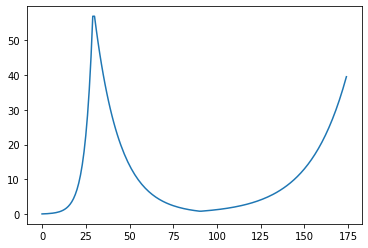

In [8]:
plt.figure()
rr = np.log(2.0)/3.0 # Initial growth rate
rlock = -0.07 # Decline rate following successful lockdown
dlock = 30 # Day of lockdown start
dstop = 91 # Day of lockdown stop
dend= 175 # Predict up to dend
rstop = 1/5 # Growth rate multiplier following lockdown stop
i0 = 0.07 # Initial value of force of infection - tuned to be like a wave in a large city
mulock = i0*np.exp(rr*np.arange(0,dlock,1))
mustop = mulock[-1]*np.exp(rlock*np.arange(0,dstop-dlock,1))
munew = mustop[-1]*(np.exp(rr*rstop*np.arange(0,dend-dstop,1)))
mu = np.concatenate([mulock,mustop, munew])
dayran = np.arange(0,len(mu),1)
plt.plot(dayran, mu)
census = mu
ld = len(census)
dayrange = range(1,ld+1) # The range of days we care about
nboot = 200
la = 1.0
# Save plot if required

In [9]:
# Simulate for each Bootstrap
nboot=200
means = np.zeros((num_trans))
counts = np.zeros((nboot,nstates,ld))
times = np.zeros((2, num_trans))
random.seed(7)
for s in tqdm(range(0,nboot)):
    
    
    kmatb = np.zeros((num_trans,num_trans))
    scalematb = np.zeros((num_trans,num_trans))
    for k in range(0,num_trans):
        ij = np.argwhere(TransNum == (k+1))[0]
        kmatb[ij[0],ij[1]] = xboot[2*k,s]
        scalematb[ij[0],ij[1]] = get_scale(xboot[2*k+1, s])
        adm = census

    for d in dayrange:      
        for i in range(0,int(adm[d-1])):
            prob_ICUstart = 0.04
            rand = np.random.uniform(0,1)
            if (rand<prob_ICUstart):
                y=1
            else:
                y = 0

            Yi = np.array([y])
            Ti = np.array([0.0])
            while ((np.sum(Qbase[y,:]) > 0.0) and (Ti[-1]<=ld)):
                zz = np.where(Qbase[y,:] > 0.0)[0]
                tti = np.zeros(len(zz))
                yyi = np.zeros(len(zz))
                for q, z in enumerate(zz):
                    k = kmatb[y,z]
                    scaleg = scalematb[y,z]
                    tti[q] = scaleg*np.random.weibull(k)
                    yyi[q] = z

                r = np.argmin(tti)
                tran = TransNum[y,:][np.nonzero(TransNum[y,:])][r]
                times[0,tran-1] += 1
                times[1, tran-1]+= tti[r]
                y = int(yyi[r])
                Yi = np.append(Yi,y)
                Ti = np.append(Ti,Ti[-1].copy() + tti[r])
            Zi = [int(np.round(x)) for x in Yi]
            Di = [(d + int(np.round(x))) for x in Ti]
            for m in range(0,len(Di)):
                j = Zi[m]
                if (Di[m]>=ld):
                    break
                if (m==(len(Di)-1)):
                    counts[s,j,Di[m]:] += 1.0
                elif (Di[m+1]>ld):
                    counts[s,j,Di[m]:ld] += 1.0
                else:
                    counts[s,j,Di[m]:Di[m+1]] += 1.0

    for t in range(0, num_trans):
        means[t] = times[1, t]/times[0, t]
   

## AFT Model from CHESS Data

In [10]:
state_names = {
    1: "Acute Ward",
    2: "ICU",
    3: "Outcome"
}
nstates = len(state_names)

In [11]:
TransNum = np.array([[0, 1, 2], [0, 0, 3], [0, 0, 0]])
num_trans = np.max(TransNum)
Qbase = TransNum.copy()
Qbase[Qbase>0]=1
ntrans = np.max(TransNum)

In [12]:
nboot = 200
xhats1 = pd.read_csv('./fitted_parameters/Hosp_ICU_AFT.csv').values
xhats1 = xhats1[:200,::2].T
xhats2 = pd.read_csv('./fitted_parameters/Hosp_outcomeNOICU_AFT.csv').values
xhats2 = xhats2[:200,::2].T
xhats3 = pd.read_csv('./fitted_parameters/ICUentryICUexit_AFT.csv').values
xhats3 = xhats3[:200,::2].T
xboot = np.zeros((2*int(num_trans), np.shape(xhats1)[1] ))
xboot[0:2, :] = xhats1
xboot[2:4, :] = xhats2
xboot[4:6, :] = xhats3

In [13]:
# Simulate for each Bootstrap
means = np.zeros(num_trans)
counts_aft = np.zeros((nboot,nstates,ld))
times = np.zeros((nboot, num_trans))
random.seed(7)
for s in tqdm(range(0,nboot)):
    
    
    kmatb = np.zeros((ntrans,ntrans))
    scalematb = np.zeros((ntrans,ntrans))
    for p in range(0,ntrans):
        ij = np.argwhere(TransNum == (p+1))[0]
        kmatb[ij[0],ij[1]] = xboot[2*p,s]
        scalematb[ij[0],ij[1]] = get_scale(xboot[2*p+1,s])
        adm = census

    for d in dayrange:      
        for i in range(0,int(adm[d-1])):
            prob_ICUstart = 0.04
            rand = np.random.uniform(0,1)
            if (rand<prob_ICUstart):
                y=1
            else:
                y = 0

            Yi = np.array([y])
            Ti = np.array([0.0])
            while ((np.sum(Qbase[y,:]) > 0.0) and (Ti[-1]<=ld)):
                zz = np.where(Qbase[y,:] > 0.0)[0]
                tti = np.zeros(len(zz))
                yyi = np.zeros(len(zz))
                for q, z in enumerate(zz):
                    k = kmatb[y,z]
                    scaleg = scalematb[y,z]
                    tti[q] = scaleg*np.random.weibull(k)
                    yyi[q] = z

                r = np.argmin(tti)
                tran = TransNum[y,:][np.nonzero(TransNum[y,:])][r]
                times[0,tran-1] += 1
                times[1, tran-1]+= tti[r]
                y = int(yyi[r])
                Yi = np.append(Yi,y)
                Ti = np.append(Ti,Ti[-1].copy() + tti[r])
            Zi = [int(np.round(x)) for x in Yi]
            Di = [(d + int(np.round(x))) for x in Ti]
            for m in range(0,len(Di)):
                j = Zi[m]
                if (Di[m]>=ld):
                    break
                if (m==(len(Di)-1)):
                    counts_aft[s,j,Di[m]:] += 1.0
                elif (Di[m+1]>ld):
                    counts_aft[s,j,Di[m]:ld] += 1.0
                else:
                    counts_aft[s,j,Di[m]:Di[m+1]] += 1.0

    for t in range(0, num_trans):
        means[t] = times[1, t]/times[0, t]
   

## TC on CHESS Data

In [14]:
xboot = pd.read_csv('./fitted_parameters/xhats_TS_alt.csv', header = None)
xboot = xboot.drop([0, 1], axis = 1).drop([2, 3], axis=0).values
xboot[[0, 1, 2, 3, 4, 5]] = xboot[[5, 4, 1, 0, 3, 2]]

In [15]:
# Simulate for each Bootstrap
means = np.zeros(num_trans)
counts_tc = np.zeros((nboot,nstates,ld))
times = np.zeros((nboot, num_trans))
random.seed(7)
for s in tqdm(range(0,nboot)):
    
    
    kmatb = np.zeros((ntrans,ntrans))
    scalematb = np.zeros((ntrans,ntrans))
    for p in range(0,ntrans):
        ij = np.argwhere(TransNum == (p+1))[0]
        kmatb[ij[0],ij[1]] = xboot[2*p,s]
        scalematb[ij[0],ij[1]] = get_scale(xboot[2*p+1,s])
        adm = census

    for d in dayrange:      
        for i in range(0,int(adm[d-1])):
            prob_ICUstart = 0.04
            rand = np.random.uniform(0,1)
            if (rand<prob_ICUstart):
                y=1
            else:
                y = 0

            Yi = np.array([y])
            Ti = np.array([0.0])
            while ((np.sum(Qbase[y,:]) > 0.0) and (Ti[-1]<=ld)):
                zz = np.where(Qbase[y,:] > 0.0)[0]
                tti = np.zeros(len(zz))
                yyi = np.zeros(len(zz))
                for q, z in enumerate(zz):
                    k = kmatb[y,z]
                    scaleg = scalematb[y,z]
                    tti[q] = scaleg*np.random.weibull(k)
                    yyi[q] = z

                r = np.argmin(tti)
                tran = TransNum[y,:][np.nonzero(TransNum[y,:])][r]
                times[0,tran-1] += 1
                times[1, tran-1]+= tti[r]
                y = int(yyi[r])
                Yi = np.append(Yi,y)
                Ti = np.append(Ti,Ti[-1].copy() + tti[r])
            Zi = [int(np.round(x)) for x in Yi]
            Di = [(d + int(np.round(x))) for x in Ti]
            for m in range(0,len(Di)):
                j = Zi[m]
                if (Di[m]>=ld):
                    break
                if (m==(len(Di)-1)):
                    counts_tc[s,j,Di[m]:] += 1.0
                elif (Di[m+1]>ld):
                    counts_tc[s,j,Di[m]:ld] += 1.0
                else:
                    counts_tc[s,j,Di[m]:Di[m+1]] += 1.0

    for t in range(0, num_trans):
        means[t] = times[1, t]/times[0, t]
   

<Figure size 1080x720 with 0 Axes>

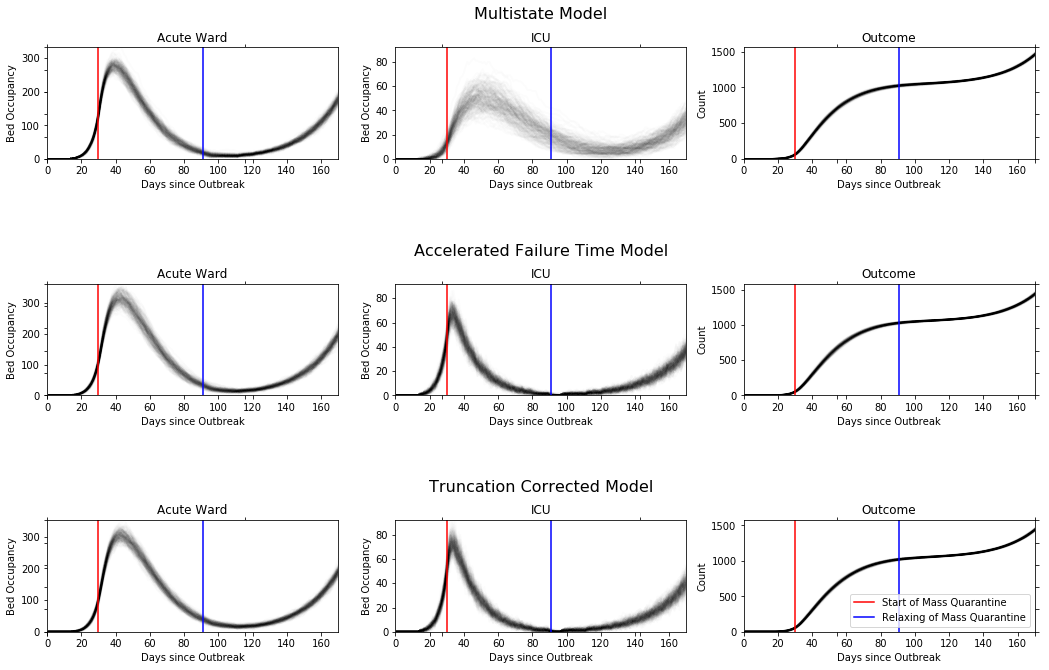

In [18]:
plt.figure(figsize=(15,10))
xlab = "Days since Outbreak"
fig, big_axes = plt.subplots( figsize=(15.0, 10.0) , nrows=3, ncols=1, sharey=True) 
subtitles = ["Multistate Model", "Accelerated Failure Time Model", "Truncation Corrected Model"]
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(subtitles[row-1], fontsize=16, y=1.2)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False

    
t = range(0, ld)
col = ['r', 'b']
label = ['Start of Mass Quarantine', 'Relaxing of Mass Quarantine']
values = [dlock, dstop]

ax = fig.add_subplot(3,3,1)
ymax = np.max(counts[:, 0, :])
for s in range(0,nboot):
    plt.plot(dayrange,counts[s,0,:],c='k',linewidth=2,alpha=0.01,zorder=0)  
for val, c, lab in zip(values, col, label):
    plt.axvline(val, label = lab, c=c)
plt.ylim([0,ymax])
ax.set_title(state_names[1])
plt.xlim([0,ld - 5])
plt.xlabel(xlab)
plt.ylabel('Bed Occupancy')


ax = fig.add_subplot(3,3,2)
ymax = np.max(counts_tc[:, 0, :])

for s in range(0,nboot):
    plt.plot(dayrange, np.sum(counts[s,[1, 2],:], 0),c='k',linewidth=2,alpha=0.01,zorder=0)  
for val, c, lab in zip(values, col, label):
    plt.axvline(val, label = lab, c=c)
plt.ylim([0,ymax])
ax.set_title(state_names[2])
plt.xlim([0,ld - 5])
plt.xlabel(xlab)
plt.ylabel('Bed Occupancy')


ax = fig.add_subplot(3,3,3)
              
for s in range(0,nboot):
    plt.plot(dayrange,np.sum(counts[s,[3,4],:],0),c='k',linewidth=2,alpha=0.01,zorder=0)  
for val, c, lab in zip(values, col, label):
    plt.axvline(val, label = lab, c=c)
ax.set_title('Outcome')
plt.xlim([0,ld - 5])
plt.ylim([0,np.max(np.sum(counts[s,[3,4],:],0))])
plt.xlabel(xlab)
plt.ylabel('Count')
    

ax = fig.add_subplot(3,3,4)
ymax = np.max(counts_aft[:, 1, :])
for s in range(0,nboot):
    plt.plot(dayrange,counts_aft[s,1,:],c='k',linewidth=2,alpha=0.01,zorder=0)  
for val, c, lab in zip(values, col, label):
    plt.axvline(val, label = lab, c=c)
plt.ylim([0,ymax])
ax.set_title(state_names[1])
plt.xlim([0,ld - 5])
plt.xlabel(xlab)
plt.ylabel('Bed Occupancy')

ax = fig.add_subplot(3,3,5)
ymax = np.max(counts_tc[:, 0, :])
for s in range(0,nboot):
    plt.plot(dayrange,counts_aft[s,0,:],c='k',linewidth=2,alpha=0.01,zorder=0)  
for val, c, lab in zip(values, col, label):
    plt.axvline(val, label = lab, c=c)
plt.ylim([0,ymax])
ax.set_title(state_names[2])
plt.xlim([0,ld - 5])
plt.xlabel(xlab)
plt.ylabel('Bed Occupancy')
    
ax = fig.add_subplot(3,3,6)
ymax = np.max(counts_aft[:, 2, :])
for s in range(0,nboot):
    plt.plot(dayrange,counts_aft[s,2,:],c='k',linewidth=2,alpha=0.01,zorder=0)  
for val, c, lab in zip(values, col, label):
    plt.axvline(val, label = lab, c=c)
plt.ylim([0,ymax])
ax.set_title(state_names[3])
plt.xlim([0,ld - 5])
plt.xlabel(xlab)
plt.ylabel('Count')
    
ax = fig.add_subplot(3,3,7)
ymax = np.max(counts_tc[:, 1, :])
for s in range(0,nboot):
    plt.plot(dayrange,counts_tc[s,1,:],c='k',linewidth=2,alpha=0.01,zorder=0)  
for val, c, lab in zip(values, col, label):
    plt.axvline(val, label = lab, c=c)
plt.ylim([0,ymax])
ax.set_title(state_names[1])
plt.xlim([0,ld - 5])
plt.xlabel(xlab)
plt.ylabel('Bed Occupancy')

ax = fig.add_subplot(3,3,8)
ymax = np.max(counts_tc[:, 0, :])
for s in range(0,nboot):
    plt.plot(dayrange,counts_tc[s,0,:],c='k',linewidth=2,alpha=0.01,zorder=0)  
for val, c, lab in zip(values, col, label):
    plt.axvline(val, label = lab, c=c)
plt.ylim([0,ymax])
ax.set_title(state_names[2])
plt.xlim([0,ld - 5])
plt.xlabel(xlab)
plt.ylabel('Bed Occupancy')
    
ax = fig.add_subplot(3,3,9)
ymax = np.max(counts_tc[:, 2, :])
for s in range(0,nboot):
    plt.plot(dayrange,counts_tc[s,2,:],c='k',linewidth=2,alpha=0.01,zorder=0)  
for val, c, lab in zip(values, col, label):
    plt.axvline(val, label = lab, c=c)
plt.legend()
plt.ylim([0,ymax])
ax.set_title(state_names[3])
plt.xlim([0,ld - 5])
plt.xlabel(xlab)
plt.ylabel('Count')
  
plt.tight_layout()

# Save to required destination